In [ ]:
import os, random, numpy as np, pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [ ]:
"""Load dataset"""

PATH = 'results.csv'
df = pd.read_csv(PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
print(df.shape)
df.head()

(2783, 11)


,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


In [ ]:
"""Create labels for the 3 classification classes: 2 - Home Win; 1 - Draw; 0 = Home Loss"""

y = np.where(df['home_score'] > df['away_score'], 2,
     np.where(df['home_score'] == df['away_score'], 1, 0))
df['label'] = y
df[['date','home_team','away_team','home_score','away_score','label']].head()

,date,home_team,away_team,home_score,away_score,label
0,1871-03-27,Scotland,England,1,0,2
1,1872-02-05,England,Scotland,2,1,2
2,1873-03-03,Scotland,England,0,0,1
3,1874-02-23,England,Scotland,1,0,2
4,1875-02-15,England,Ireland,2,0,2


In [ ]:
"""Create Team ID for embedding"""

teams = pd.Index(sorted(set(df['home_team']) | set(df['away_team'])))
team2id = {t:i for i,t in enumerate(teams)}
df['home_id'] = df['home_team'].map(team2id)
df['away_id'] = df['away_team'].map(team2id)
len(team2id), list(team2id)[:10]

(10,
 ['Argentina',
  'Australia',
  'England',
  'France',
  'Ireland',
  'Italy',
  'New Zealand',
  'Scotland',
  'South Africa',
  'Wales'])

In [ ]:
"""
  Start with one row per match (home vs away).
  You build a team–match panel with one row per (team, match) (so each match appears twice: once from the home team’s POV and once from the away team’s POV).
  On that panel you compute shifted rolling stats (form, goals, win/draw rates, etc.) so that every feature for a match uses only past information.
  Finally, you split the panel back into “home features” and “away features” and join them onto the original match rows
"""

def make_team_panel(df):
    home = df[['date','home_team','home_score','away_score']].copy()
    home = home.rename(columns={'home_team':'team','home_score':'team_score','away_score':'opp_score'})
    home['is_home'] = 1

    away = df[['date','away_team','away_score','home_score']].copy()
    away = away.rename(columns={'away_team':'team','away_score':'team_score','home_score':'opp_score'})
    away['is_home'] = 0

    panel = pd.concat([home, away], ignore_index=True)
    panel['gd'] = panel['team_score'] - panel['opp_score']
    panel['win']  = (panel['team_score'] > panel['opp_score']).astype(int)
    panel['draw'] = (panel['team_score'] == panel['opp_score']).astype(int)
    panel['loss'] = (panel['team_score'] < panel['opp_score']).astype(int)
    panel = panel.sort_values(['team','date']).reset_index(drop=True)
    return panel

panel = make_team_panel(df)

def add_rolling(panel, windows=(3,5)):
    panel = panel.sort_values(['team','date']).copy()
    # shift 1 step to avoid leakage
    cols = ['team_score','opp_score','gd','win','draw','loss','is_home']

    panel[cols] = panel.groupby('team')[cols].shift(1)
    for w in windows:
        panel[f'pts_{w}']  = (panel.groupby('team')['win'].rolling(w).sum().reset_index(level=0,drop=True)*3 +
                             panel.groupby('team')['draw'].rolling(w).sum().reset_index(level=0,drop=True)*1)
        panel[f'gd_{w}']   = panel.groupby('team')['gd'].rolling(w).sum().reset_index(level=0,drop=True)
        panel[f'gf_{w}']   = panel.groupby('team')['team_score'].rolling(w).mean().reset_index(level=0,drop=True)
        panel[f'ga_{w}']   = panel.groupby('team')['opp_score'].rolling(w).mean().reset_index(level=0,drop=True)
        panel[f'home_rate_{w}'] = panel.groupby('team')['is_home'].rolling(w).mean().reset_index(level=0,drop=True)
        panel[f'win_rate_{w}']  = panel.groupby('team')['win'].rolling(w).mean().reset_index(level=0,drop=True)
        panel[f'draw_rate_{w}'] = panel.groupby('team')['draw'].rolling(w).mean().reset_index(level=0,drop=True)
    return panel

panel = add_rolling(panel)

# split back into home/away feature tables
home_feats = panel[panel['is_home']==1].copy().add_prefix('home_')
away_feats = panel[panel['is_home']==0].copy().add_prefix('away_')

# join to original match rows
tmp = df.merge(home_feats, left_on=['date','home_team'], right_on=['home_date','home_team'], how='left') \
         .merge(away_feats, left_on=['date','away_team'], right_on=['away_date','away_team'], how='left')

for c in ['home_date','away_date']:
    if c in tmp.columns:
        tmp = tmp.drop(columns=c)

# ⚙️ Mean imputation for missing values
# This fills all NaN values (from early matches with missing rolling stats)
# with the mean of that feature column.
tmp = tmp.fillna(tmp.select_dtypes(include='number').mean())



tmp.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,...,away_home_rate_3,away_win_rate_3,away_draw_rate_3,away_pts_5,away_gd_5,away_gf_5,away_ga_5,away_home_rate_5,away_win_rate_5,away_draw_rate_5
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,...,0.349564,0.481347,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,...,0.349564,0.481347,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,...,0.349564,0.481347,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,...,0.349564,0.481347,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,...,0.349564,0.481347,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159


In [ ]:
"""Elo ratings are extra features, computed over time, representing dynamic team strength.

Every team has a numerical rating (e.g., 1500).
When two teams play:

  - The higher-rated team is expected to win.
  - If the weaker team wins, it gains more points (a big upset).
  - If the stronger team wins, it gains fewer points (expected result).

After each match, both teams’ ratings are updated based on:

  - Expected result (probability of winning, given ratings)
  - Actual result (win, draw, loss)
  - A K-factor (how fast ratings change — like a learning rate)


Formula:
  RH = Home team’s current Elo rating
  RA = Away team’s current Elo rating
  K = adjustment factor (typically 10–30)
  h = home advantage constant (e.g., +50 Elo points for the home team)
"""

def build_elo(df, k=20, home_adv=50):
    teams = sorted(set(df['home_team']) | set(df['away_team']))
    R = {t:1500.0 for t in teams}
    rows = []
    for _, r in df.sort_values('date').iterrows():
        h, a = r['home_team'], r['away_team']
        Ra, Rb = R[h], R[a]
        Ea = 1 / (1 + 10 ** ((Rb - (Ra + home_adv)) / 400))
        if r['home_score'] > r['away_score']:
            Sa, Sb = 1.0, 0.0
        elif r['home_score'] < r['away_score']:
            Sa, Sb = 0.0, 1.0
        else:
            Sa, Sb = 0.5, 0.5
        rows.append({'date': r['date'], 'home_team': h, 'away_team': a,
                     'elo_home_pre': Ra, 'elo_away_pre': Rb})
        R[h] = Ra + k * (Sa - Ea)
        R[a] = Rb + k * ((1 - Sa) - (1 - Ea))
    return pd.DataFrame(rows)

elo = build_elo(df)
tmp = tmp.merge(elo, on=['date','home_team','away_team'], how='left')
tmp.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,...,away_draw_rate_3,away_pts_5,away_gd_5,away_gf_5,away_ga_5,away_home_rate_5,away_win_rate_5,away_draw_rate_5,elo_home_pre,elo_away_pre
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,...,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159,1500.000000,1500.000000
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,...,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159,1491.429262,1508.570738
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,...,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159,1499.513672,1500.486328
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,...,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159,1501.888156,1498.111844
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,...,0.040698,7.569657,1.699489,17.889278,17.54938,0.447411,0.490591,0.042159,1510.352592,1500.000000


In [ ]:
"""Creating contextual features: context features describe the environment or conditions surrounding an event — not the main participants,
but where and under what circumstances it occurs.

Home Advantage (captured via neutral)"
  - Teams playing at home win significantly more often than when away.
  - Familiar stadium, fan support, less travel fatigue, local climate → all boost performance.
  - By contrast, neutral matches (e.g., World Cup games, neutral venues) level the field.
  - The model needs to know this to avoid confusing “strong team” with “always plays at home.

So neutral is a binary flag that lets your neural network learn different priors for home vs neutral games.

Competition Type (captured via comp_id):
  Different tournaments and contexts produce different competitive dynamics:
    - In the Six Nations, all teams are Tier 1 Europeans, fairly balanced.
    - In the Rugby Championship, southern hemisphere giants dominate.
    - In World Cups, smaller teams face elite opponents — lots of mismatches.
    - In Friendly Tests, coaches experiment with lineups, so variance increases.

  If you mix all these matches together, the model might think that “Italy always loses” — when in fact, that’s only true in Six Nations, not against Tier 2 sides in friendlies.

  Adding comp_id tells the model:
  “This match belongs to competition X, where matchups tend to have outcome patterns like this.”

  So the model can learn different statistical tendencies by competition."""

# Replace NaN with placeholder and ensure strings
tmp['competition'] = tmp['competition'].fillna('Unknown').astype(str)
# Convert neutral column into integers 1 or 0 (True or False)
tmp['neutral'] = tmp['neutral'].astype(int)
# Maps each competition to a numeric ID
comp2id = {c:i for i,c in enumerate(sorted(tmp['competition'].unique()))}
tmp['comp_id'] = tmp['competition'].map(comp2id)
len(comp2id), list(comp2id)[:5]

(800,
 ['1871 Scotland v England International',
  '1871–72 Home Nations International',
  '1872–73 Home Nations International',
  '1873–74 Home Nations International',
  '1874–75 Home Nations International'])

In [ ]:
"""Create the Feature Matrix (X) and Target (Y):
This section builds the model table (model_df) with pre-match features for each game and prepares train/val/test sets for PyTorch.
We explicitly separate continuous and categorical inputs so we can standardize the former and embed the latter."""

feat_cols = []
feat_cols += ['elo_home_pre','elo_away_pre']
# short-term form for both teams over rolling windows (3,5,10 matches), all shifted to avoid leakage
for w in (3,5):
    feat_cols += [f'home_pts_{w}', f'home_gd_{w}', f'home_gf_{w}', f'home_ga_{w}',
                  f'home_win_rate_{w}', f'home_draw_rate_{w}',
                  f'away_pts_{w}', f'away_gd_{w}', f'away_gf_{w}', f'away_ga_{w}',
                  f'away_win_rate_{w}', f'away_draw_rate_{w}']
# contextual signals:
# - neutral: home advantage proxy (0/1)
# - home_id/away_id: team identifiers (categorical → embeddings)
# - comp_id: competition identifier (categorical → embedding)
feat_cols += ['neutral','home_id','away_id','comp_id']

model_df = tmp.dropna(subset=feat_cols + ['label']).copy()
model_df = model_df.sort_values('date').reset_index(drop=True)

# Split features into continous vs categorical data
cont_cols = [c for c in feat_cols if c not in ['home_id','away_id','comp_id']] #continous
cat_cols  = ['home_id','away_id','comp_id'] #categorical

# Standardize continous features
scaler = StandardScaler()
model_df[cont_cols] = scaler.fit_transform(model_df[cont_cols])

# Split data into train, test, and validate
# Compute sizes
N = len(model_df)
i_tr, i_va = int(N*0.70), int(N*0.85)

train = model_df.iloc[:i_tr]
val   = model_df.iloc[i_tr:i_va]
test  = model_df.iloc[i_va:]

# Show breakdown
print("📊 Dataset Split Summary")
print(f"Total samples: {N:,}")
print(f"Training set:   {len(train):,} ({len(train)/N:.2%})")
print(f"Validation set: {len(val):,} ({len(val)/N:.2%})")
print(f"Test set:       {len(test):,} ({len(test)/N:.2%})")

# Optional: check date ranges (since chronological split)
print("\n🗓️ Date ranges per split:")
print(f"Train: {train['date'].min().date()} → {train['date'].max().date()}")
print(f"Val:   {val['date'].min().date()} → {val['date'].max().date()}")
print(f"Test:  {test['date'].min().date()} → {test['date'].max().date()}")


# Extract numpy arrays for PyTorch use.
# Continous arrays (features) will be the Multi-layer Perceptron input (An MLP is the classic example of a feedforward network, where information travels in a single direction from the input layer, through one or more hidden layers, to the output layer)
# Categorical arrays (features) are used as embedding lookups.
X_tr_cont = train[cont_cols].values.astype('float32')
X_va_cont = val[cont_cols].values.astype('float32')
X_te_cont = test[cont_cols].values.astype('float32')
X_tr_cat  = train[cat_cols].values.astype('int64')
X_va_cat  = val[cat_cols].values.astype('int64')
X_te_cat  = test[cat_cols].values.astype('int64')
y_tr = train['label'].values.astype('int64')
y_va = val['label'].values.astype('int64')
y_te = test['label'].values.astype('int64')

X_tr_cont.shape, X_tr_cat.shape, y_tr.shape, model_df[['label']].value_counts().to_dict()

📊 Dataset Split Summary
Total samples: 2,784
Training set:   1,948 (69.97%)
Validation set: 418 (15.01%)
Test set:       418 (15.01%)

🗓️ Date ranges per split:
Train: 1871-03-27 → 2007-08-26
Val:   2007-09-07 → 2015-10-18
Test:  2015-10-24 → 2024-08-17


((1948, 27), (1948, 3), (1948,), {(2,): 1585, (0,): 1078, (1,): 121})

In [ ]:
"""This section wraps our preprocessed features and labels into a custom PyTorch Dataset class designed for models
that use both continuous features (e.g. Elo, form stats) and categorical features (e.g. team IDs, competition IDs)."""

class MatchDatasetEmb(Dataset):
    def __init__(self, X_cont, X_cat, y=None):
        self.Xc = torch.tensor(X_cont, dtype=torch.float32)
        self.Xg = torch.tensor(X_cat,  dtype=torch.long)
        self.y  = None if y is None else torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.Xc)
    def __getitem__(self, i):
        if self.y is None:
            return self.Xc[i], self.Xg[i]
        return self.Xc[i], self.Xg[i], self.y[i]

tr_ds = MatchDatasetEmb(X_tr_cont, X_tr_cat, y_tr)
va_ds = MatchDatasetEmb(X_va_cont, X_va_cat, y_va)
te_ds = MatchDatasetEmb(X_te_cont, X_te_cat, y_te)

tr_loader = DataLoader(tr_ds, batch_size=128, shuffle=True)
va_loader = DataLoader(va_ds, batch_size=256)
te_loader = DataLoader(te_ds, batch_size=256)

In [ ]:
"""
What this architecture does
Inputs:
 - cont (continuous features): Elo ratings, rolling form stats, venue flag, etc. (standardized floats).
 - cat (categorical features): home_id, away_id, comp_id (integer IDs).

Embeddings:
  Each categorical ID is mapped to a learnable dense vector:
    - emb_home(home_id) ∈ ℝ^{emb_dim_team}
    - emb_away(away_id) ∈ ℝ^{emb_dim_team}
    - emb_comp(comp_id) ∈ ℝ^{emb_dim_comp}
  These vectors act like compact “profiles” for teams and competitions, learned end-to-end from data.

Concatenation:
  - The network concatenates [continuous || home_embed || away_embed || comp_embed] into one feature vector.

MLP head:
  - A small feedforward network (ReLU + Dropout) transforms the concatenated vector and outputs 3 logits → softmax during loss.

Why an MLP?
  - Per-match snapshot, not a sequence: Our features summarize past information (via shifted rolling windows and Elo) into a single pre-match vector.
    There’s no raw time sequence fed to the model, so a recurrent layer isn’t necessary.

  - Expressive embeddings: MLPs are the standard strong baseline for tabular data. With team/competition embeddings, the model
    learns latent factors (team strength, style, competition effects) and combines them with numeric context (Elo, recent form).

  - Regularization-friendly: The head uses Dropout and modest hidden sizes (128 → 64) to reduce overfitting on a relatively compact feature space.

How the embeddings help
  - Team identity: Teams recur across years and competitions. Fixed one-hot encodings would be sparse and high-dimensional;
    embeddings learn dense vectors capturing persistent attributes (strength, style, discipline) and interact with continuous features.

  - Competition context: Different tournaments have different difficulty/variance profiles. A small comp_id embedding lets the model learn
    competition-specific biases (e.g., stronger home advantage, more/less draws).

"""
class RugbyClf(nn.Module):
    def __init__(self, n_cont, team_vocab, comp_vocab, emb_dim_team=16, emb_dim_comp=8, hidden1=128, hidden2=64):
        super().__init__()
        # Categorical embeddings
        self.emb_home = nn.Embedding(team_vocab, emb_dim_team)
        self.emb_away = nn.Embedding(team_vocab, emb_dim_team)
        self.emb_comp = nn.Embedding(comp_vocab, emb_dim_comp)
        in_dim = n_cont + emb_dim_team*2 + emb_dim_comp
        #Multi-layer Perceptron Model
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),     nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(hidden2, 3) # 3 classes: 0=Home Loss; 1 = Draw; 2 = Home Win
        )
    def forward(self, cont, cat):
        eh = self.emb_home(cat[:,0])
        ea = self.emb_away(cat[:,1])
        ec = self.emb_comp(cat[:,2])
        x = torch.cat([cont, eh, ea, ec], dim=1)
        return self.mlp(x)

team_vocab = len(team2id)
comp_vocab = len(comp2id)
model = RugbyClf(n_cont=len(cont_cols), team_vocab=team_vocab, comp_vocab=comp_vocab, hidden1=128, hidden2=64).to(DEVICE)
model

RugbyClf(
  (emb_home): Embedding(10, 16)
  (emb_away): Embedding(10, 16)
  (emb_comp): Embedding(800, 8)
  (mlp): Sequential(
    (0): Linear(in_features=67, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [ ]:
"""The model was trained using Adam optimization (learning rate = 1e-3, weight decay = 1e-4) and Cross-Entropy loss over.
Validation accuracy was computed after each epoch, and the model checkpoint with the highest validation accuracy was retained to prevent overfitting."""


""" ---- Weighted-Class Cross Entropy Logic ----
Findings: was unable to predict true draws and therefore not useful.
# y_tr is the array of training labels (0,1,2)
class_counts = np.bincount(y_tr)  #[the number of losses, the number of draws, the number of wins]
total = class_counts.sum() # total number of samples
# Rarer classes get higher weights.
class_weights = total / (class_counts + 1e-6) #compute the class weights, inversely proportional to frequency.

# to tensor on device - Converts the NumPy array into a PyTorch tensor that lives on the same device as your model (CPU or GPU).
w = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=w)"""




criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

"""
Training:
Loops over EPOCHS (full passes through training data).
  - model.train() activates dropout and gradient tracking.
  - For each mini-batch:
    - Move tensors to GPU/CPU (DEVICE).
    - Zero gradients to prevent accumulation.
    - Forward pass -> logits = model(Xc, Xg) combines continuous and categorical embeddings and compute loss between logits and true labels (yb).
    - Backward pass -> loss.backward() computes gradients.
    - Optimizer step updates weights."""
best_state, best_val = None, -1
EPOCHS = 100
for ep in range(EPOCHS):
    model.train()
    for Xc, Xg, yb in tr_loader:
        Xc, Xg, yb = Xc.to(DEVICE), Xg.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(Xc, Xg)
        loss = criterion(logits, yb)
        loss.backward(); optimizer.step()

    """
    Validation:
      - Switches to evaluation mode (model.eval()), which disables dropout and gradient updates.
      - Iterates over the validation set (va_loader) to measure generalization accuracy.
      - Uses torch.no_grad() for efficiency (no gradient storage).
      - argmax(1) extracts the predicted class index with the highest logit score.
      - val_acc is simply (correct predictions) / (total samples).
    """
    model.eval(); correct=total=0
    with torch.no_grad():
        for Xc, Xg, yb in va_loader:
            Xc, Xg, yb = Xc.to(DEVICE), Xg.to(DEVICE), yb.to(DEVICE)
            pred = model(Xc, Xg).argmax(1)
            correct += (pred==yb).sum().item(); total += len(yb)
    val_acc = correct/total if total>0 else 0.0
    if val_acc > best_val:
        best_val = val_acc
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
    print(f"epoch {ep+1:02d}  val_acc={val_acc:.4f}")

if best_state:
    model.load_state_dict(best_state)
print('Best val_acc:', best_val)

epoch 01  val_acc=0.5718
epoch 02  val_acc=0.5718
epoch 03  val_acc=0.5718
epoch 04  val_acc=0.5885
epoch 05  val_acc=0.6364
epoch 06  val_acc=0.6722
epoch 07  val_acc=0.6890
epoch 08  val_acc=0.7081
epoch 09  val_acc=0.7201
epoch 10  val_acc=0.7225
epoch 11  val_acc=0.7392
epoch 12  val_acc=0.7368
epoch 13  val_acc=0.7440
epoch 14  val_acc=0.7512
epoch 15  val_acc=0.7608
epoch 16  val_acc=0.7608
epoch 17  val_acc=0.7632
epoch 18  val_acc=0.7632
epoch 19  val_acc=0.7488
epoch 20  val_acc=0.7584
epoch 21  val_acc=0.7608
epoch 22  val_acc=0.7512
epoch 23  val_acc=0.7488
epoch 24  val_acc=0.7440
epoch 25  val_acc=0.7512
epoch 26  val_acc=0.7512
epoch 27  val_acc=0.7488
epoch 28  val_acc=0.7536
epoch 29  val_acc=0.7512
epoch 30  val_acc=0.7512
epoch 31  val_acc=0.7488
epoch 32  val_acc=0.7440
epoch 33  val_acc=0.7488
epoch 34  val_acc=0.7464
epoch 35  val_acc=0.7464
epoch 36  val_acc=0.7464
epoch 37  val_acc=0.7440
epoch 38  val_acc=0.7464
epoch 39  val_acc=0.7464
epoch 40  val_acc=0.7512


In [ ]:
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for Xc, Xg, yb in te_loader:
        Xc, Xg = Xc.to(DEVICE), Xg.to(DEVICE)
        pred = model(Xc, Xg).argmax(1).cpu().numpy()
        y_pred.extend(pred.tolist()); y_true.extend(yb.numpy().tolist())
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
cm

              precision    recall  f1-score   support

           0     0.6803    0.6173    0.6472       162
           1     0.0000    0.0000    0.0000        11
           2     0.7380    0.8163    0.7752       245

    accuracy                         0.7177       418
   macro avg     0.4728    0.4779    0.4741       418
weighted avg     0.6962    0.7177    0.7052       418



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[100,   0,  62],
       [  2,   0,   9],
       [ 45,   0, 200]])

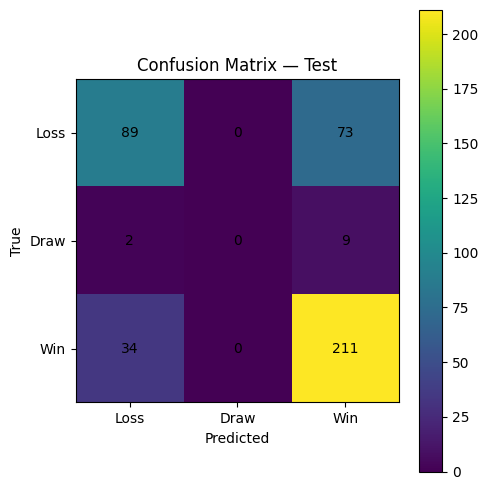

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Test')
plt.colorbar()
ticks = [0,1,2]
plt.xticks(ticks, ['Loss','Draw','Win'])
plt.yticks(ticks, ['Loss','Draw','Win'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show();